# Multi-instrument fitting

In this notebook, we will demonstrate `juliet`'s capability of simultaneously fitting multiple instruments with joint transit and eclipse model.

- Data used: WASP-18, TESS Sector 2, 3, 29, 30 and 69 (Data can be found in the 'Data' folder)
- Model: Transit and Eclipse model (same transit depth for each sector, but different eclipse depths for each sector)
- `juliet` version: `dev` version of `juliet` for which the pull request is opened ([this](https://github.com/Jayshil/juliet/tree/dev) version)

First of all, let us import necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import juliet
import os
import matplotlib.gridspec as gd
from scipy.optimize import minimize
from tqdm import tqdm
import astropy.units as u
import multiprocessing
multiprocessing.set_start_method('fork')

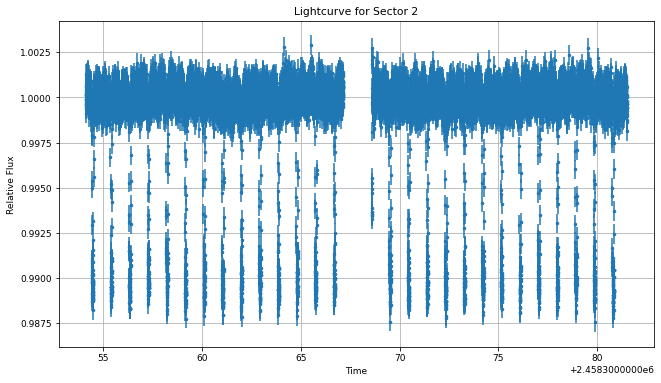

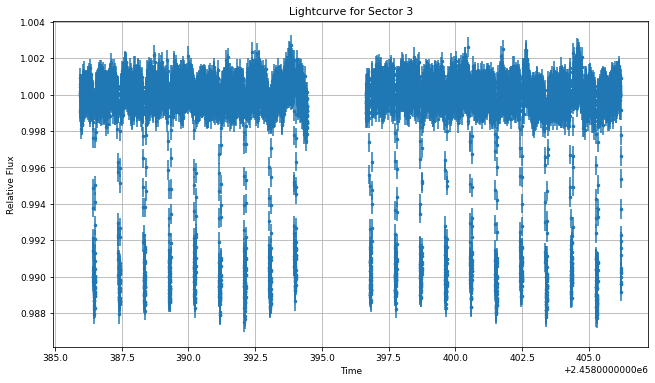

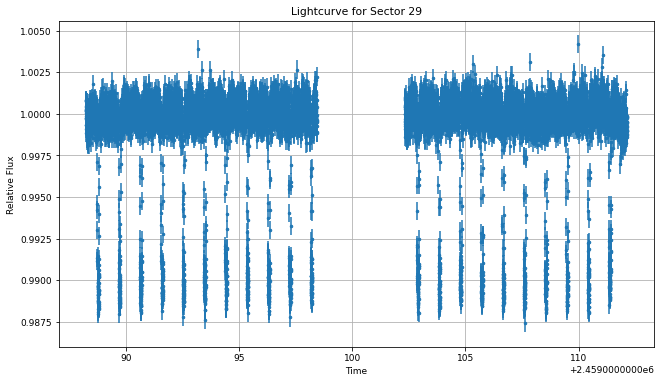

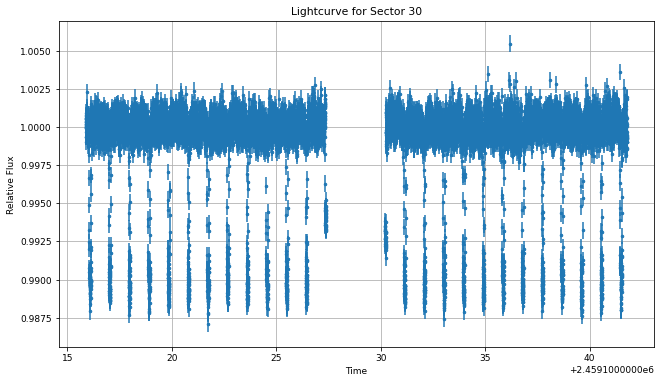

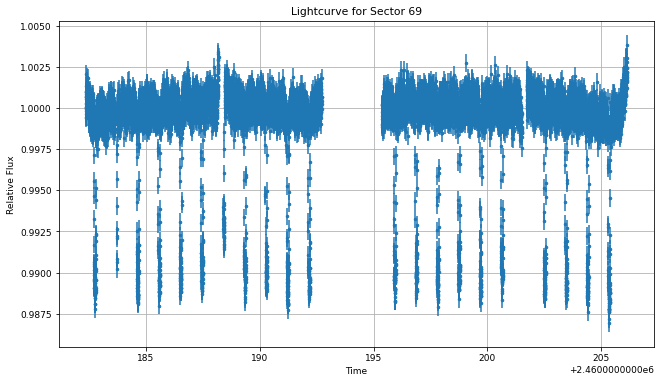

In [2]:
# Loading and storing the data the way juliet understands
instruments = ['TESS2', 'TESS3', 'TESS29', 'TESS30', 'TESS69']
tim, fl, fle = {}, {}, {}
for i in range(len(instruments)):
    tim7, fl7, fle7 = np.loadtxt(os.getcwd() + '/Data/WASP-18_' + instruments[i] + '.dat',\
                                 usecols=(0,1,2), unpack=True)
    tim[instruments[i]], fl[instruments[i]], fle[instruments[i]] = tim7, fl7, fle7

# And visualise the data
for i in tim.keys():
    plt.figure(figsize=(16/1.5, 9/1.5))
    plt.errorbar(tim[i], fl[i], yerr=fle[i], fmt='.')
    plt.xlabel('Time')
    plt.ylabel('Relative Flux')
    plt.title('Lightcurve for Sector ' + i[4:])
    plt.grid()
    plt.show()

The data looks nice! Transits of the planet is clearly visible.

Since, we are interested in fitting transit and eclipse, we would,
- Include priors on eclipse depth, `fp`
- Include LDCs.
- Note that `p` and `fp` both are now planetary _and_ instrumental parameters. And we have two instruments: TESS2 and TESS3. In the present examples, we keep the same planet-to-star radius ratio for both of the instruments. To do so, we will use `p_p1_TESS2_TESS3` in prior list.
- However, we would keep different `fp` for different instruments (this is useful if we want to check the temporal variability of the parameter). But since sector 2-3, sector 29-30 are observed very near to each other, we will provide a common eclipse depth parameter for them, e.g., _three_ parameters for eclipse depths, `fp_p1_TESS2_TESS3`, `fp_p1_TESS29_TESS30` and `fp_p1_TESS69` in prior. (Yes, this is doable with `juliet`, and that too with no extra effort! More the reasons to use `juliet`)
- Note also that while listing priors for `p` and `fp`, the planet number goes _before_ instrument. That means, `p_p1_TESS2` is valid, but `p_TESS2_p1` is not valid.
- In this example, we share `p_p1` for both instruments, but this is not necessary. One can provide different `p_p1` for both instruments.
- Although `fp` is planetary _and_ instrumental parameter, the secondary eclipse time is still _only_ planetary parameter, i.e., we will use `t_secondary_p1`.

In [3]:
# Some planetary parameters (to provide priors)
# All parameters are taken from Cortés-Zuleta et al. 2020
per, per_err = 0.94145223, 0.00000024
bjd0, bjd0_err = 2456740.80560, 0.00019
rho, rho_err = ((0.795 * u.g/u.cm**3).to(u.kg/u.m**3)).value, \
     ((np.sqrt((0.110**2) + (0.089**2)) * u.g/u.cm**3).to(u.kg/u.m**3)).value
ecc, omega = 0.0091, 269   # From Shporer et al. (2018)

## Computing transit and eclipse time for the epoch from the data
cycle = round((tim[instruments[-1]][-1] - bjd0)/per)
tc1 = np.random.normal(bjd0, bjd0_err, 100000) + cycle*np.random.normal(per, per_err, 100000)
tc2 = tc1 + (np.random.normal(per, per_err, 100000)/2)

tc0, tc0_err = np.median(tc1), np.std(tc1)
tc02, tc02_err = np.median(tc2), np.std(tc2)

# And priros (Note that p and fp are planetary and instrumental parameters):
par_P = ['P_p1', 't0_p1', 'p_p1_' + '_'.join(instruments), 'b_p1',\
         'q1_' + '_'.join(instruments), 'q2_' + '_'.join(instruments), 'rho',\
         'fp_p1_TESS2_TESS3', 'fp_p1_TESS29_TESS30', 'fp_p1_TESS69',\
         't_secondary_p1', 'ecc_p1', 'omega_p1']
dist_P = ['normal', 'normal', 'uniform', 'uniform',\
          'uniform', 'uniform', 'normal',\
          'uniform', 'uniform', 'uniform',\
          'normal', 'fixed', 'fixed']
hyper_P = [[per, per_err], [tc0, tc0_err], [0., 1.], [0., 1.],\
           [0.,1.], [0.,1.], [rho, rho_err],\
           [0.e-6, 500.e-6], [0.e-6, 500.e-6], [0.e-6, 500.e-6],\
           [tc02, tc02_err], ecc, omega]

## Instrumental and GP parameters
par_ins, dist_ins, hyper_ins = [], [], []
for i in range(len(instruments)):
    par_ins = par_ins + ['mdilution_' + instruments[i], 'mflux_' + instruments[i], \
                         'sigma_w_' + instruments[i]]
    dist_ins = dist_ins + ['fixed', 'normal', 'loguniform']
    hyper_ins = hyper_ins + [1., [0., 0.1], [0.1, 10000.]]

par_gp, dist_gp, hyper_gp = [], [], []
for i in range(len(instruments)):
    par_gp = par_gp + ['GP_sigma_' + instruments[i], 'GP_timescale_' + instruments[i],\
                       'GP_rho_' + instruments[i]]
    dist_gp = dist_gp + ['loguniform', 'loguniform', 'loguniform']
    hyper_gp = hyper_gp + [[1e-5, 10000.], [1e-3, 1e2], [1e-3, 1e2]]

par_tot = par_P + par_ins + par_gp
dist_tot = dist_P + dist_ins + dist_gp
hyper_tot = hyper_P + hyper_ins + hyper_gp

priors_tot = juliet.utils.generate_priors(par_tot, dist_tot, hyper_tot)

In [4]:
# And fitting it!
dataset = juliet.load(priors=priors_tot, t_lc=tim, y_lc=fl, yerr_lc=fle,\
    GP_regressors_lc=tim, out_folder=os.getcwd() + '/Analysis/Multi-Transit-Eclipse_4')
res = dataset.fit(sampler = 'dynesty', nthreads=8)

Detected dynesty sampler output files --- extracting from /Users/japa6985/Documents/Codes/juliet-examples/Analysis/Multi-Transit-Eclipse_4/_dynesty_NS_posteriors.pkl


In [5]:
os.system("cat Analysis/Multi-Transit-Eclipse_4/posteriors.dat")

# Parameter Name     	 	 Median       	 	 Upper 68 CI  	 	 Lower 68 CI 
P_p1               	 	 0.9414524041 	 	 0.0000000239 	 	 0.0000000244
a_p1               	 	 3.4945956609 	 	 0.0163670033 	 	 0.0147470415
t0_p1              	 	 2460206.2947833054 	 	 0.0000351947 	 	 0.0000345409
p_p1_TESS2_TESS3_TESS29_TESS30_TESS69 	 	 0.0978977862 	 	 0.0002096726 	 	 0.0002181367
b_p1               	 	 0.3789883252 	 	 0.0112540854 	 	 0.0134448986
q1_TESS2_TESS3_TESS29_TESS30_TESS69 	 	 0.2291117973 	 	 0.0168685998 	 	 0.0161344427
q2_TESS2_TESS3_TESS29_TESS30_TESS69 	 	 0.2854316692 	 	 0.0302211212 	 	 0.0280992269
rho                	 	 910.8487906859 	 	 12.8579987157 	 	 11.4825193498
fp_p1_TESS2_TESS3  	 	 0.0003546562 	 	 0.0000183188 	 	 0.0000191895
fp_p1_TESS29_TESS30 	 	 0.0004145430 	 	 0.0000201238 	 	 0.0000205200
fp_p1_TESS69       	 	 0.0003323774 	 	 0.0000308329 	 	 0.0000315834
t_secondary_p1     	 	 2460206.7645883714 	 	 0.0003153109 	 	 0.0002948930
mflux_TESS2       

0

0606711 	 	 0.0104361287 	 	 0.0077987875
GP_rho_TESS3       	 	 55.5952762712 	 	 29.0468028476 	 	 24.2421562036
GP_sigma_TESS29    	 	 0.0000372276 	 	 0.0000465911 	 	 0.0000208276
GP_timescale_TESS29 	 	 0.0041130159 	 	 0.0053794841 	 	 0.0022976005
GP_rho_TESS29      	 	 66.5625351209 	 	 22.3936264958 	 	 23.9726700227
GP_sigma_TESS30    	 	 0.0000250782 	 	 0.0000497481 	 	 0.0000120702
GP_timescale_TESS30 	 	 0.0320922778 	 	 0.0300100076 	 	 0.0212725481
GP_rho_TESS30      	 	 42.4407605500 	 	 34.3046644558 	 	 22.8475251510
GP_sigma_TESS69    	 	 0.0000490453 	 	 0.0001143172 	 	 0.0000321237
GP_timescale_TESS69 	 	 0.0121387733 	 	 0.0232645335 	 	 0.0084490059
GP_rho_TESS69      	 	 57.3404452160 	 	 27.2218131417 	 	 25.4663724577


The posteriors look good for most of the planetary parameters and seems to agree with their corresponding values from the literature.

Let's now visualise our results to make sure that everything was smooth.

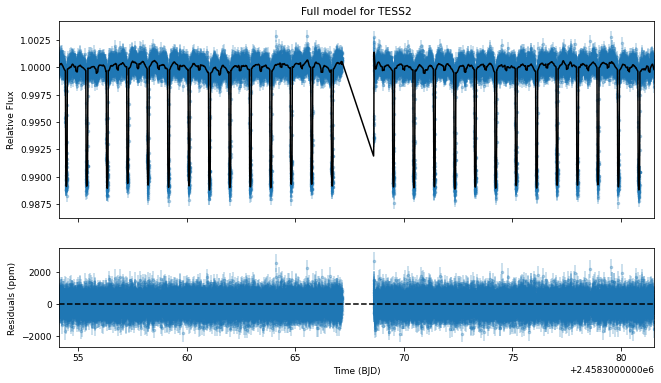

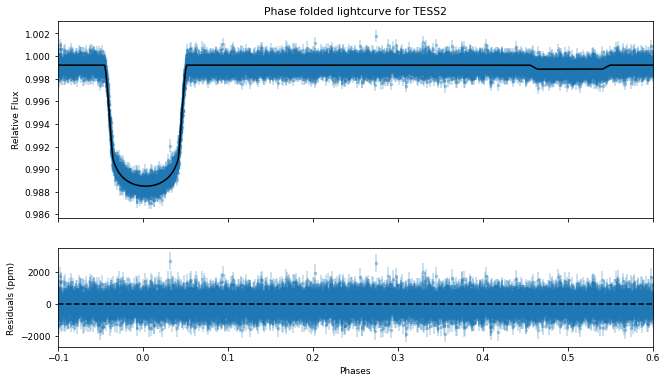

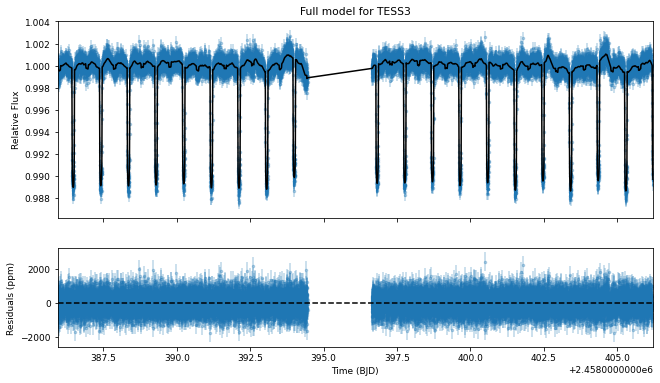

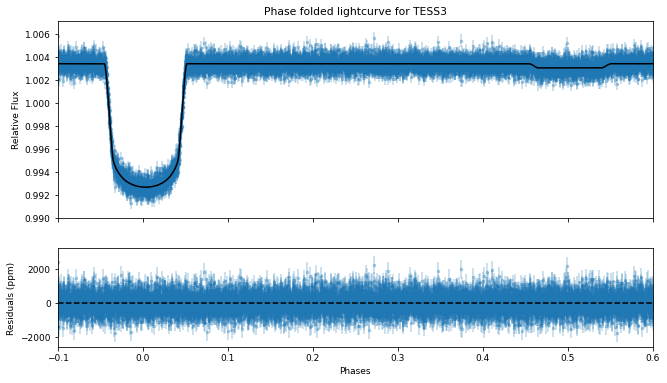

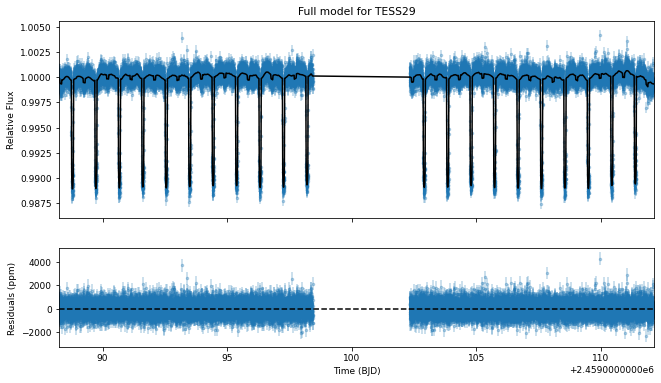

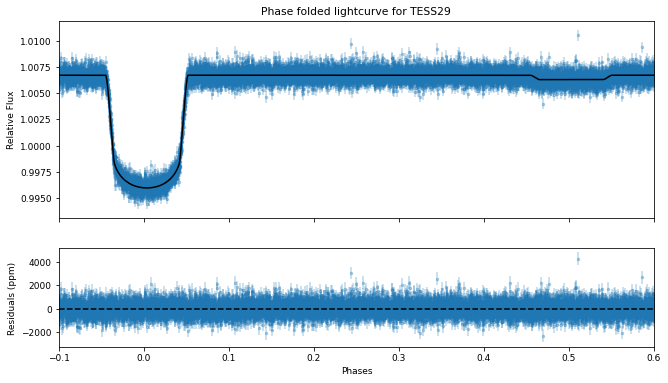

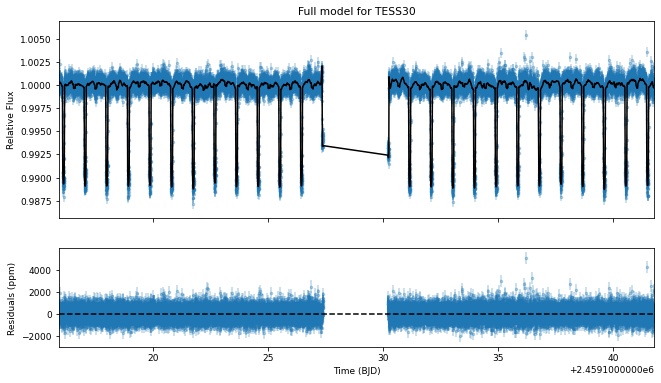

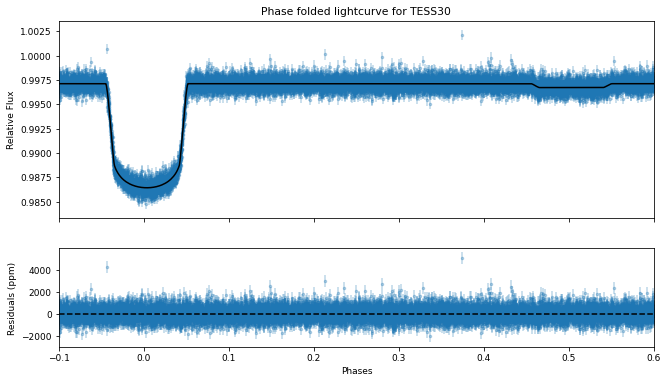

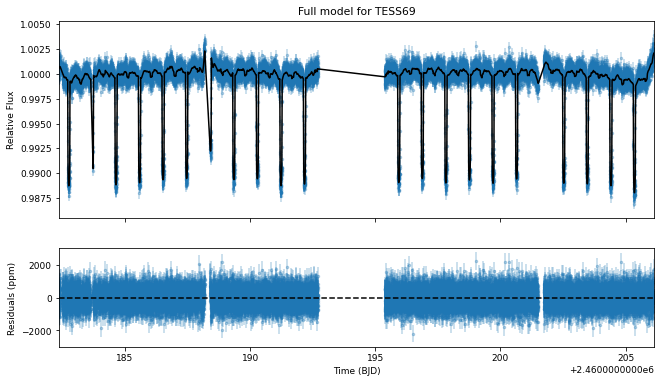

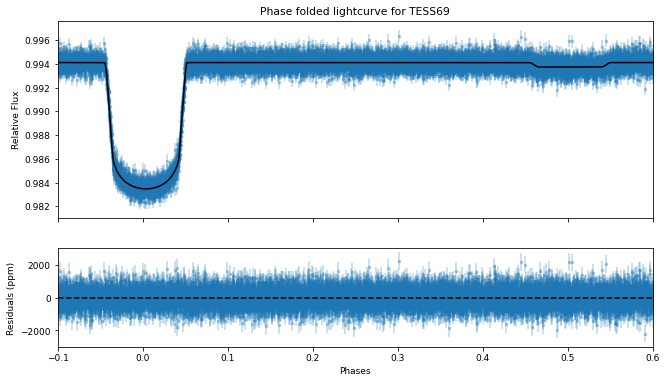

In [6]:
for i in tim.keys():
    # juliet best fit model
    model = res.lc.evaluate(i)
    gp_model = res.lc.model[i]['GP']
    transit_model = res.lc.model[i]['deterministic']
    # Making a plot
    fig = plt.figure(figsize=(16/1.5,9/1.5))
    gs = gd.GridSpec(2,1, height_ratios=[2,1])

    # Top panel
    ax1 = plt.subplot(gs[0])
    ax1.errorbar(tim[i], fl[i], yerr=fle[i], fmt='.', alpha=0.3)
    ax1.plot(tim[i], model, c='k', zorder=100)
    ax1.set_ylabel('Relative Flux')
    ax1.set_xlim(np.min(tim[i]), np.max(tim[i]))
    ax1.xaxis.set_major_formatter(plt.NullFormatter())

    # Bottom panel
    ax2 = plt.subplot(gs[1])
    ax2.errorbar(tim[i], (fl[i]-model)*1e6, yerr=fle[i]*1e6, fmt='.', alpha=0.3)
    ax2.axhline(y=0.0, c='black', ls='--', zorder=100)
    ax2.set_ylabel('Residuals (ppm)')
    ax2.set_xlabel('Time (BJD)')
    ax2.set_xlim(np.min(tim[i]), np.max(tim[i]))

    ax1.set_title('Full model for ' + i)
    plt.show()

    # Phase folded lightcurves:
    phs = juliet.utils.get_phases(tim[i], per, bjd0, phmin=0.8)
    idx = np.argsort(phs)
    # Making a plot
    fig = plt.figure(figsize=(16/1.5,9/1.5))
    gs = gd.GridSpec(2,1, height_ratios=[2,1])

    # Top panel
    ax1 = plt.subplot(gs[0])
    ax1.errorbar(phs, fl[i]-gp_model, yerr=fle[i], fmt='.', alpha=0.3)
    ax1.plot(phs[idx], transit_model[idx], c='k', zorder=100)
    ax1.set_ylabel('Relative Flux')
    ax1.set_xlim(-0.1, 0.6)
    #ax1.set_ylim(0.998, 1.002)
    ax1.xaxis.set_major_formatter(plt.NullFormatter())

    # Bottom panel
    ax2 = plt.subplot(gs[1])
    ax2.errorbar(phs, (fl[i]-model)*1e6, yerr=fle[i]*1e6, fmt='.', alpha=0.3)
    ax2.axhline(y=0.0, c='black', ls='--', zorder=100)
    ax2.set_ylabel('Residuals (ppm)')
    ax2.set_xlabel('Phases')
    ax2.set_xlim(-0.1, 0.6)

    ax1.set_title('Phase folded lightcurve for ' + i)
    plt.show()

This is fantastic!

Since it looks like there is a variability, we will now plot eclipse depths as a function of time.

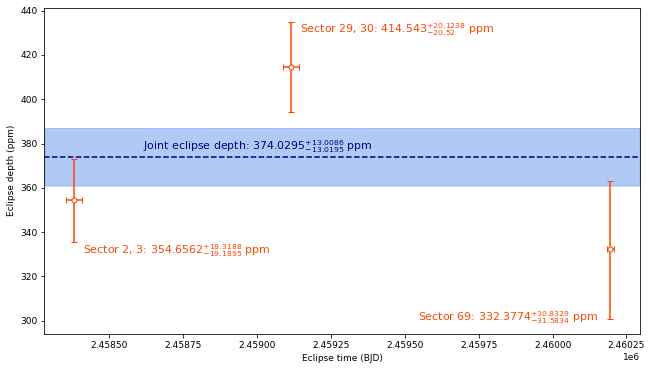

In [7]:
# Eclipse timing
t0_post, t2_post = res.posteriors['posterior_samples']['t0_p1'], \
    res.posteriors['posterior_samples']['t_secondary_p1']
per_post = res.posteriors['posterior_samples']['P_p1']

tmid2 = (tim['TESS2'][0] + tim['TESS3'][-1]) / 2
cy23 = round((tmid2 - np.median(t2_post)) / np.median(per_post))
bjd_sec23 = np.median(t2_post) + (cy23 * np.median(per_post))

tmid3 = (tim['TESS29'][0] + tim['TESS30'][-1]) / 2
cy2930 = round((tmid3 - np.median(t2_post)) / np.median(per_post))
bjd_sec2930 = np.median(t2_post) + (cy2930 * np.median(per_post))

cy69 = round((np.mean(tim['TESS69']) - np.median(t2_post)) / np.median(per_post))
bjd_sec69 = np.median(t2_post) + (cy69 * np.median(per_post))

all_bjds = np.array([bjd_sec23, bjd_sec2930, bjd_sec69])
all_bjd_lerr = np.array([bjd_sec23 - tim['TESS2'][0], bjd_sec2930 - tim['TESS29'][0],\
                          bjd_sec69 - tim['TESS69'][0]])
all_bjd_uerr = np.array([tim['TESS3'][-1] - bjd_sec23, tim['TESS30'][-1] -  bjd_sec2930,\
                          tim['TESS69'][-1] - bjd_sec69])

# Eclipse depths
qua_ecl_sec23 = \
     juliet.utils.get_quantiles(res.posteriors['posterior_samples']['fp_p1_TESS2_TESS3']*1e6)
ecl_med23, ecl_uerr23, ecl_derr23 = qua_ecl_sec23[0], qua_ecl_sec23[1]-qua_ecl_sec23[0],\
     qua_ecl_sec23[0]-qua_ecl_sec23[2]

qua_ecl_sec2930 = \
     juliet.utils.get_quantiles(res.posteriors['posterior_samples']['fp_p1_TESS29_TESS30']*1e6)
ecl_med2930, ecl_uerr2930, ecl_derr2930 = qua_ecl_sec2930[0], qua_ecl_sec2930[1]-qua_ecl_sec2930[0],\
       qua_ecl_sec2930[0]-qua_ecl_sec2930[2]

qua_ecl_sec69 =\
     juliet.utils.get_quantiles(res.posteriors['posterior_samples']['fp_p1_TESS69']*1e6)
ecl_med69, ecl_uerr69, ecl_derr69 = qua_ecl_sec69[0], qua_ecl_sec69[1]-qua_ecl_sec69[0],\
     qua_ecl_sec69[0]-qua_ecl_sec69[2]

all_ecl_med = np.array([ecl_med23, ecl_med2930, ecl_med69])
all_ecl_uerr = np.array([ecl_uerr23, ecl_uerr2930, ecl_uerr69])
all_ecl_derr = np.array([ecl_derr23, ecl_derr2930, ecl_derr69])

# Joint eclipse depth (Computed from 'multi-instrument-2.ipynb' file)
fp_joint_med, fp_joint_uerr, fp_joint_derr = 0.0003740295*1e6, 0.0000130086*1e6, 0.0000130195*1e6

plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(all_bjds, all_ecl_med, xerr=[all_bjd_lerr, all_bjd_uerr], \
             yerr=[all_ecl_derr, all_ecl_uerr], fmt='o', c='orangered', mfc='white', capsize=3)
plt.fill_between(x=np.linspace(all_bjds[0]-100, all_bjds[-1]+100, 1000),\
                 y1=fp_joint_med+fp_joint_uerr, y2=fp_joint_med-fp_joint_derr,\
                 color='cornflowerblue', alpha=0.5)
plt.axhline(fp_joint_med, ls='--', color='navy')
plt.text(all_bjds[1]-500, fp_joint_med+3,\
         r'Joint eclipse depth: ' + str(np.around(fp_joint_med,4)) + '$^{+' +\
         str(np.around(fp_joint_uerr,4)) + '}_{-' + str(np.around(fp_joint_derr,4)) + '}$ ppm',\
         fontsize=11, color='navy')

plt.text(all_bjds[0]+30, 330,\
     r'Sector 2, 3: ' + str(np.around(ecl_med23,4)) + '$^{+' + str(np.around(ecl_uerr23,4))\
     + '}_{-' + str(np.around(ecl_derr23,4)) + '}$ ppm',\
     color='orangered', fontsize=11)

plt.text(all_bjds[1]+30, 430,\
     r'Sector 29, 30: ' + str(np.around(ecl_med2930,4)) + '$^{+' + str(np.around(ecl_uerr2930,4))\
     + '}_{-' + str(np.around(ecl_derr2930,4)) + '}$ ppm',\
     color='orangered', fontsize=11)

plt.text(all_bjds[2]-650, 300,\
     r'Sector 69: ' + str(np.around(ecl_med69,4)) + '$^{+' + str(np.around(ecl_uerr69,4))\
     + '}_{-' + str(np.around(ecl_derr69,4)) + '}$ ppm',\
     color='orangered', fontsize=11)

plt.xlabel('Eclipse time (BJD)')
plt.ylabel('Eclipse depth (ppm)')
plt.xlim([all_bjds[0]-100, all_bjds[-1]+100])

plt.savefig(os.getcwd() + '/fp_with_time.png', dpi=500, facecolor='white')

And, let's also compute rate of change of eclipse depth,

In [8]:
slopes23 = np.zeros(len(res.posteriors['posterior_samples']['fp_p1_TESS2_TESS3']))
inters23 = np.zeros(len(slopes23))

for i in tqdm(range(len(slopes23))):
    def chi2(x):
        sl1, in1 = x
        xdata = np.array([0, all_bjds[1]-all_bjds[0]]) / 365
        ydata = np.array([res.posteriors['posterior_samples']['fp_p1_TESS2_TESS3'][i]*1e6,\
                          res.posteriors['posterior_samples']['fp_p1_TESS29_TESS30'][i]*1e6])
        model = (sl1 * xdata) + in1
        return np.sum((ydata - model)**2)
    soln = minimize(chi2, x0=np.array([35, 300]))
    slopes23[i], inters23[i] = soln.x

slopes36, inters36 = np.zeros(len(slopes23)), np.zeros(len(slopes23))
for i in tqdm(range(len(slopes23))):
    def chi2(x):
        sl1, in1 = x
        xdata = np.array([0, all_bjds[2]-all_bjds[1]]) / 365
        ydata = np.array([res.posteriors['posterior_samples']['fp_p1_TESS29_TESS30'][i]*1e6,\
                          res.posteriors['posterior_samples']['fp_p1_TESS69'][i]*1e6])
        model = (sl1 * xdata) + in1
        return np.sum((ydata - model)**2)
    soln = minimize(chi2, x0=np.array([35, 300]))
    slopes36[i], inters36[i] = soln.x

print('Rate of change between Sector 2-3 and 29-30:\
      {:.4f} +/- {:.4f} ppm/yr'.format(np.median(slopes23), np.std(slopes23)))
print('Rate of change between Sector 29-30 and 69:\
      {:.4f} +/- {:.4f} ppm/yr'.format(np.median(slopes36), np.std(slopes36)))

100%|██████████| 58696/58696 [02:13<00:00, 439.61it/s]

Rate of change between Sector 2-3 and 29-30:      30.0840 +/- 12.9932 ppm/yr
Rate of change between Sector 29-30 and 69:      -27.9513 +/- 12.5331 ppm/yr


And, this is how eclipse depth posteriors look like:

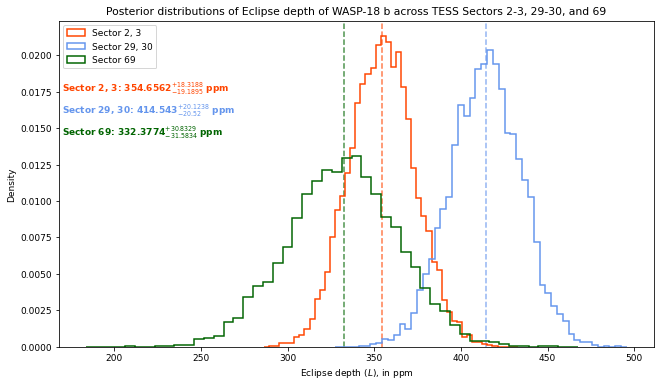

In [9]:
# This is to plot the distribution of eclipse depth across the sectors.

# Loding the distributions first
## Sector 2-3
fp14 = (res.posteriors['posterior_samples']['fp_p1_TESS2_TESS3'])*1e6
qua14 = juliet.utils.get_quantiles(fp14)
L14, L14_u, L14_d = qua14[0], qua14[1]-qua14[0], qua14[0]-qua14[2]
L14, L14_u, L14_d = np.around(L14,4), np.around(L14_u,4), np.around(L14_d, 4)
## Sector 29-30
fp40 = (res.posteriors['posterior_samples']['fp_p1_TESS29_TESS30'])*1e6
qua40 = juliet.utils.get_quantiles(fp40)
L40, L40_u, L40_d = qua40[0], qua40[1]-qua40[0], qua40[0]-qua40[2]
L40, L40_u, L40_d = np.around(L40,4), np.around(L40_u,4), np.around(L40_d, 4)
## Sector 69
fp41 = (res.posteriors['posterior_samples']['fp_p1_TESS69'])*1e6
qua41 = juliet.utils.get_quantiles(fp41)
L41, L41_u, L41_d = qua41[0], qua41[1]-qua41[0], qua41[0]-qua41[2]
L41, L41_u, L41_d = np.around(L41,4), np.around(L41_u,4), np.around(L41_d,4)


plt.figure(figsize=(16/1.5,9/1.5))
# Sector 14
plt.hist(fp14, bins=50, density=True, histtype='step', color='orangered', label='Sector 2, 3', \
         lw=1.5, zorder=10)
plt.axvline(x=L14, ls='--', color='orangered', alpha=0.7, zorder=5)

# Sector 40
plt.hist(fp40, bins=50, density=True, histtype='step', color='cornflowerblue', label='Sector 29, 30',\
          lw=1.5, zorder=10)
plt.axvline(x=L40, ls='--', color='cornflowerblue', alpha=0.7, zorder=5)

# Sector 41
plt.hist(fp41, bins=50, density=True, histtype='step', color='darkgreen', label='Sector 69', lw=1.5,\
         zorder=10)
plt.axvline(x=L41, ls='--', color='darkgreen', alpha=0.7, zorder=5)

xpos = 170
ypos = 0.0175
diff = 0.0015

# Text
plt.text(xpos, ypos,\
     r'Sector 2, 3: ' + str(L14) + '$^{+' + str(L14_u) + '}_{-' + str(L14_d) + '}$ ppm',\
     color='orangered', fontweight='bold')
plt.text(xpos, ypos - diff,\
     r'Sector 29, 30: ' + str(L40) + '$^{+' + str(L40_u) + '}_{-' + str(L40_d) + '}$ ppm',\
     color='cornflowerblue', fontweight='bold')
plt.text(xpos, ypos - 2*diff,\
     r'Sector 69: ' + str(L41) + '$^{+' + str(L41_u) + '}_{-' + str(L41_d) + '}$ ppm',\
     color='darkgreen', fontweight='bold')

plt.xlabel(r'Eclipse depth ($L$), in ppm')
plt.title('Posterior distributions of Eclipse depth of WASP-18 b across TESS Sectors 2-3, 29-30, and 69')

plt.ylabel('Density')
plt.legend()
#plt.show()
plt.savefig(os.getcwd() + '/fp.png', dpi=500, facecolor='white')